# Run the following code if working in collab

In [ ]:
# Clone the entire repo.
!git clone -l -s https://github.com/cimat-ris/TF-PathPred.git clonedrep

import os
os.chdir("./clonedrep")

!pip install pykalman

# Testing the Transformer

This notebook enables the testing of the prediction of the transformer model for the datasets of ETH and UCY. It also gives a visualization of such predictions, and a visualization of the attention weight matrices

In [1]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

import tensorflow as tf
from test_TF import test_model, print_sol
import matplotlib.pyplot as plt
import numpy as np
import os

from tools.trajectories import traj_to_real_coordinates

# Generate testing information

Run the cell bellow if you wish to generate the testing information. If you only want to visualize, go on to the next section.

In [4]:
path = "./"
#choose a dataset
test_dataset = "UCY-univ3"

test_path = path + f"testing_data/{test_dataset}/"

try: os.mkdir(path+"testing_data")
except: pass
try: os.mkdir(path+f"testing_data/{test_dataset}")
except: pass

ade,fde,weights,trajs,transformer = test_model([test_dataset],path)

ade,fde = np.array(ade), np.array(fde)

np.save(test_path+"ade.npy", ade)
np.save(test_path+"fde.npy", fde)
np.save(test_path+"inp.npy", trajs[0])
np.save(test_path+"tar.npy", trajs[1])
np.save(test_path+"pred.npy", trajs[2])

Loading trajlets from:  ./trajlets\UCY-univ3-trl.npy
Latest checkpoint restored!!
calculating predictions
0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200,

In [3]:
transformer.summary()

Model: "transformer"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder (Encoder)            multiple                  299136    
_________________________________________________________________
decoder (Decoder)            multiple                  597888    
_________________________________________________________________
multi_modal (multi_modal)    multiple                  5160      
Total params: 902,184
Trainable params: 902,184
Non-trainable params: 0
_________________________________________________________________


# Visualizing solution

Just run the cell bellow changing the name of the dataset you wish to visualize and change the value in the input box to visualize different trajectories. The red one is the observed trajectory, the blue one is the target, and the green ones are the possible outcomes predicted. If you wish to visualize a mode in particular just add a comma and the number of mode to visualize, with no spaces. e.g. "0,0"

General: ADE: 0.5219761383787876 FDE: 0.9102589186093759


interactive(children=(Text(value='0', description='x'), Output()), _dom_classes=('widget-interact',))

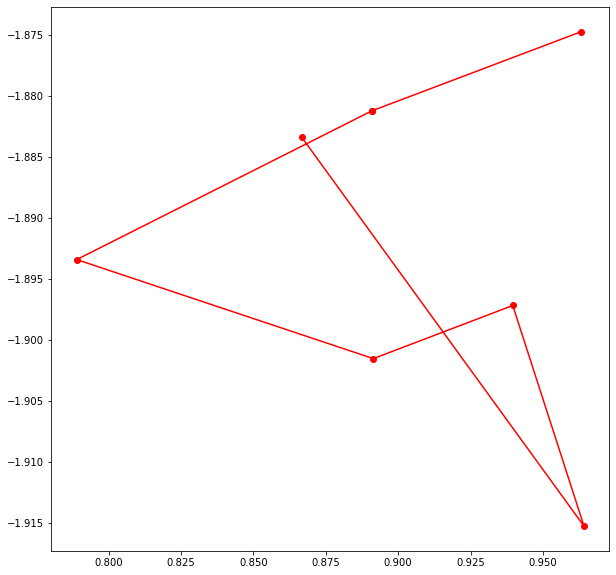

In [10]:
path = "./"
#choose a dataset
test_dataset = "UCY-univ3"

test_path = path + f"testing_data/{test_dataset}/"
reference_path = path + f"datasets/ETH/seq_eth/reference.png"
H_path = path + f"datasets/ETH/seq_eth/H.txt"

H = np.loadtxt(H_path)
H = np.linalg.inv(H)
img = plt.imread(reference_path)

ade = np.load(test_path+"ade.npy")
fde = np.load(test_path+"fde.npy")
inp = np.load(test_path+"inp.npy")
tar = np.load(test_path+"tar.npy")
pred = np.load(test_path+"pred.npy")

print("General: ADE:", np.mean(ade),"FDE:", np.mean(fde))

def f(x):
    x = x.split(',')
    if len(x) == 1:
        try:
            x = int(x[0])
        except:
            print("Error: Input was not an integer")
            return

        if x >= len(ade):
            print("There aren't that many trajectories")
            return
        #print_sol(inp[x],tar[x],pred[x],None)
        a = traj_to_real_coordinates(inp[x],H)
        b = traj_to_real_coordinates(tar[x],H)
        c = traj_to_real_coordinates(pred[x],H)
        print_sol(a,b,c,None)
        
        print(f"trajectory {x}:","ADE:", ade[x],"FDE:", fde[x])
        
    elif len(x) == 2:
        try:
            k = int(x[1])
            x = int(x[0])
        except:
            print("Error: Inputs were not integers")
            return

        if x >= len(ade):
            print("There aren't that many trajectories")
            return
        #print_sol(inp[x],tar[x],pred[x][k:(k+1)],img)
        a = inp[x]#traj_to_real_coordinates(inp[x],H)
        b = tar[x]#traj_to_real_coordinates(tar[x],H)
        c = pred[x][k]#traj_to_real_coordinates(pred[x][k],H)
        print_sol(a,b,None,None)#np.array([c]),None)
        print(f"trajectory {x}:","ADE:", ade[x],"FDE:", fde[x])
    else:
        print("the format is not valid")

interact(f, x="0");